#Imports

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
#import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
#import albumentations as A
import tensorflow_datasets as tfds
#import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy, Precision, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

# Data Download

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/

In [ ]:
! rmdir ~/.kaggle

rmdir: failed to remove '/root/.kaggle': Directory not empty


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 #The command "chmod 600 /root/.kaggle/kaggle.json" changes the file permissions for the file "/root/.kaggle/kaggle.json"
 #to readable and writable only by the owner of the file. The "600" permission is a symbolic notation that means the owner
 #has read and write permissions (6), and all other users (0) have no permissions (0).
 #This command is often used to secure sensitive files by limiting access to them.

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 306M/309M [00:12<00:00, 21.2MB/s]
100% 309M/309M [00:12<00:00, 25.5MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# Configuration

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"



```

```

# Dataset Loading

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[125.      , 125.      , 125.      ],
         [125.8125  , 125.8125  , 125.8125  ],
         [126.      , 126.      , 126.      ],
         ...,
         [ 63.3125  ,  63.3125  ,  63.3125  ],
         [ 63.625   ,  63.625   ,  63.625   ],
         [ 62.      ,  62.      ,  62.      ]],

        [[125.      , 125.      , 125.      ],
         [125.8125  , 125.8125  , 125.8125  ],
         [126.      , 126.      , 126.      ],
         ...,
         [ 60.367188,  60.367188,  60.367188],
         [ 59.867188,  59.867188,  59.867188],
         [ 59.5625  ,  59.5625  ,  59.5625  ]],

        [[125.6875  , 125.6875  , 125.6875  ],
         [125.94141 , 125.94141 , 125.94141 ],
         [126.      , 126.      , 126.      ],
         ...,
         [ 57.625   ,  57.625   ,  57.625   ],
         [ 57.195312,  57.195312,  57.195312],
         [ 58.3125  ,  58.3125  ,  58.3125  ]],

        ...,

        [[ 87.5     ,  87.5     ,

# Data Visualization

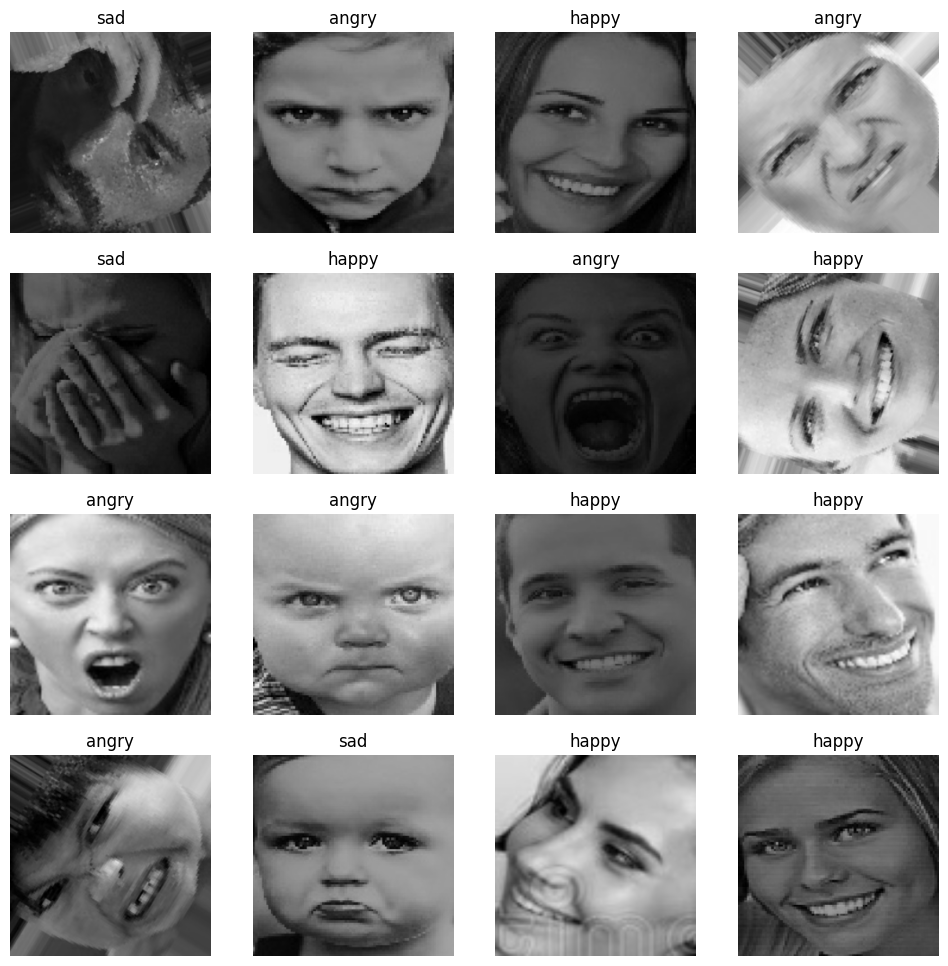

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Data Augmentation

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

# Data Preparation

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

# Modeling

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3)),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

# ResNet34

# Custom Conv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

# Residual Block

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


#Complete Network

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

# Transfer Learning (EfficientNet)

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

# FineTuning (EfficienNet)

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

# Training

# CallBacks

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

# Train

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
#metrics = [SparseCategoricalAccuracy(name = "accuracy")]


In [ ]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = [checkpoint_callback]
)

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 0.8184 - accuracy: 0.6877 - top_k_accuracy: 0.8979
Epoch 1: val_accuracy improved from -inf to 0.73968, saving model to best_weights
213/213 [==============================] - 166s 689ms/step - loss: 0.8184 - accuracy: 0.6877 - top_k_accuracy: 0.8979 - val_loss: 0.6115 - val_accuracy: 0.7397 - val_top_k_accuracy: 0.9091
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.5852 - accuracy: 0.7654 - top_k_accuracy: 0.9307
Epoch 2: val_accuracy improved from 0.73968 to 0.77656, saving model to best_weights
213/213 [==============================] - 140s 655ms/step - loss: 0.5852 - accuracy: 0.7654 - top_k_accuracy: 0.9307 - val_loss: 0.5747 - val_accuracy: 0.7766 - val_top_k_accuracy: 0.9223
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7909 - top_k_accuracy: 0.9434
Epoch 3: val_accuracy did not improve from 0.77656
213/213 [==============================] 

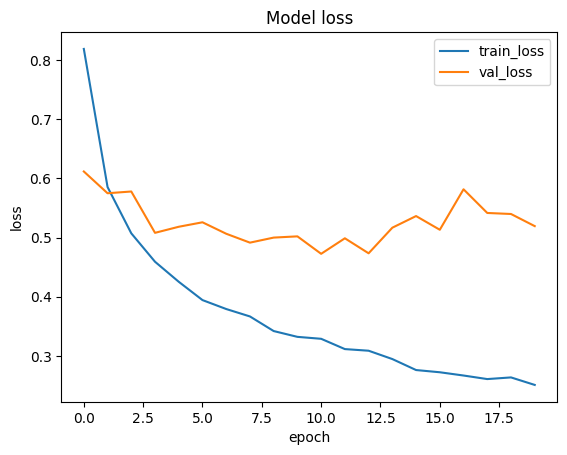

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

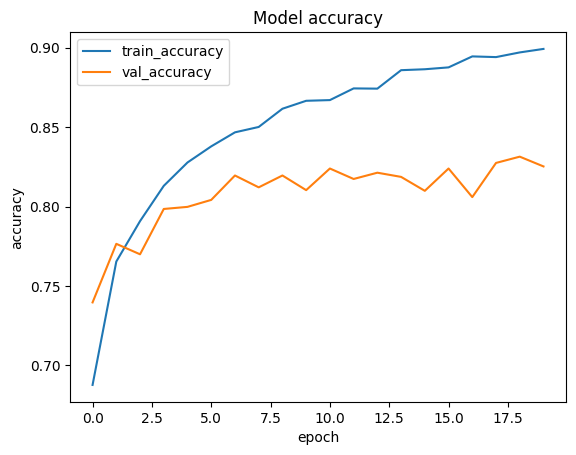

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [ ]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 132s 58ms/step - loss: 0.6949 - accuracy: 0.7669 - top_k_accuracy: 0.9210


[0.6948541402816772, 0.7669007778167725, 0.9209833145141602]

In [ ]:
resnet_34.load_weights('best_weights')

In [ ]:
resnet_34.evaluate(validation_dataset)

2278/2278 [==============================] - 27s 12ms/step - loss: 0.5112 - accuracy: 0.8446 - top_k_accuracy: 0.9442


[0.511168360710144, 0.8446004986763, 0.9442493319511414]

In [ ]:
pretrained_model.load_weights('best_weights')

In [ ]:
pretrained_model.evaluate(validation_dataset)

2278/2278 [==============================] - 47s 20ms/step - loss: 0.5397 - accuracy: 0.8314 - top_k_accuracy: 0.9442


[0.5397186875343323, 0.8314310908317566, 0.9442493319511414]

# Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

happy


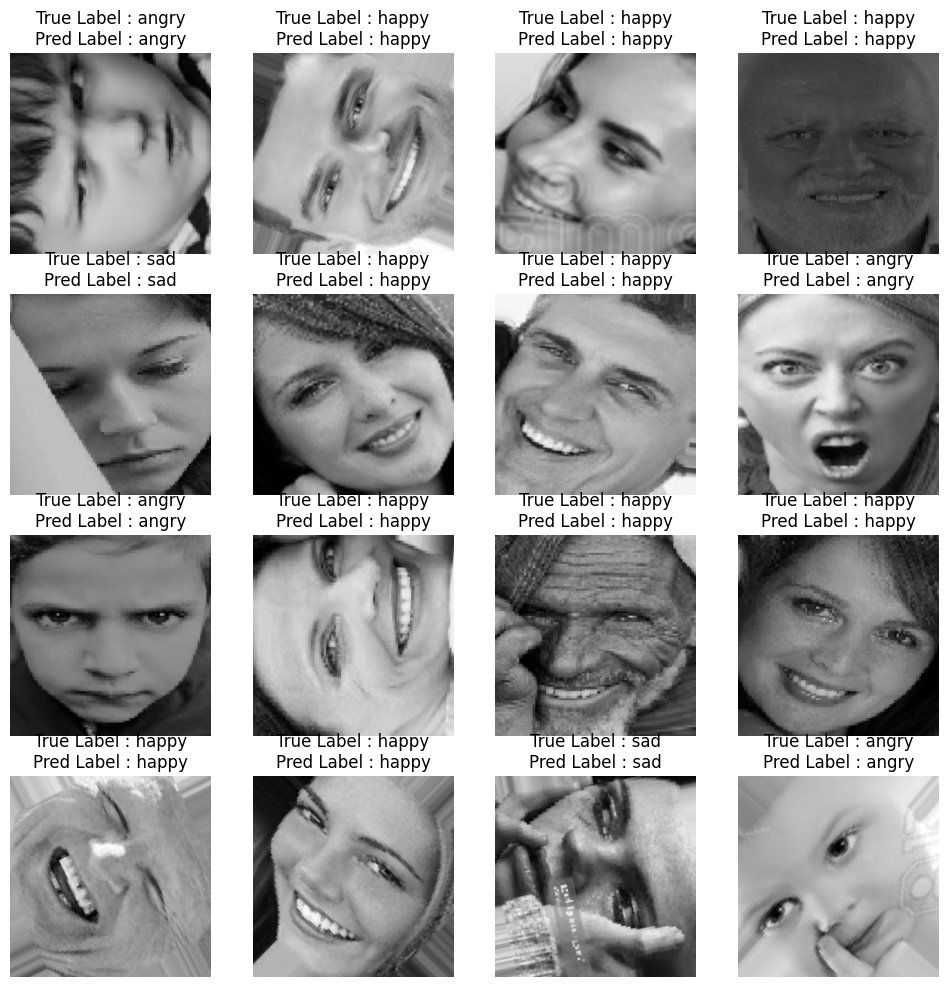

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" "Pred Label : "
              + CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

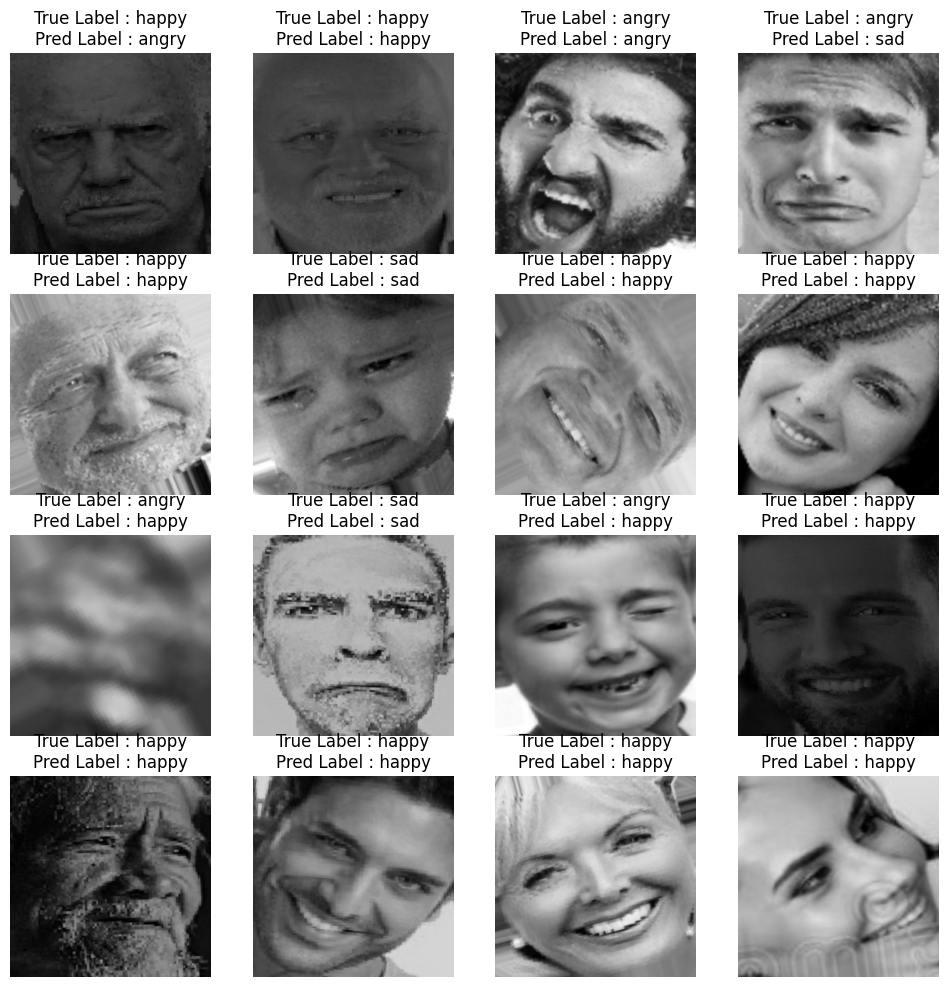

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" "Pred Label : "
              + CONFIGURATION['CLASS_NAMES'][tf.argmax(resnet_34(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

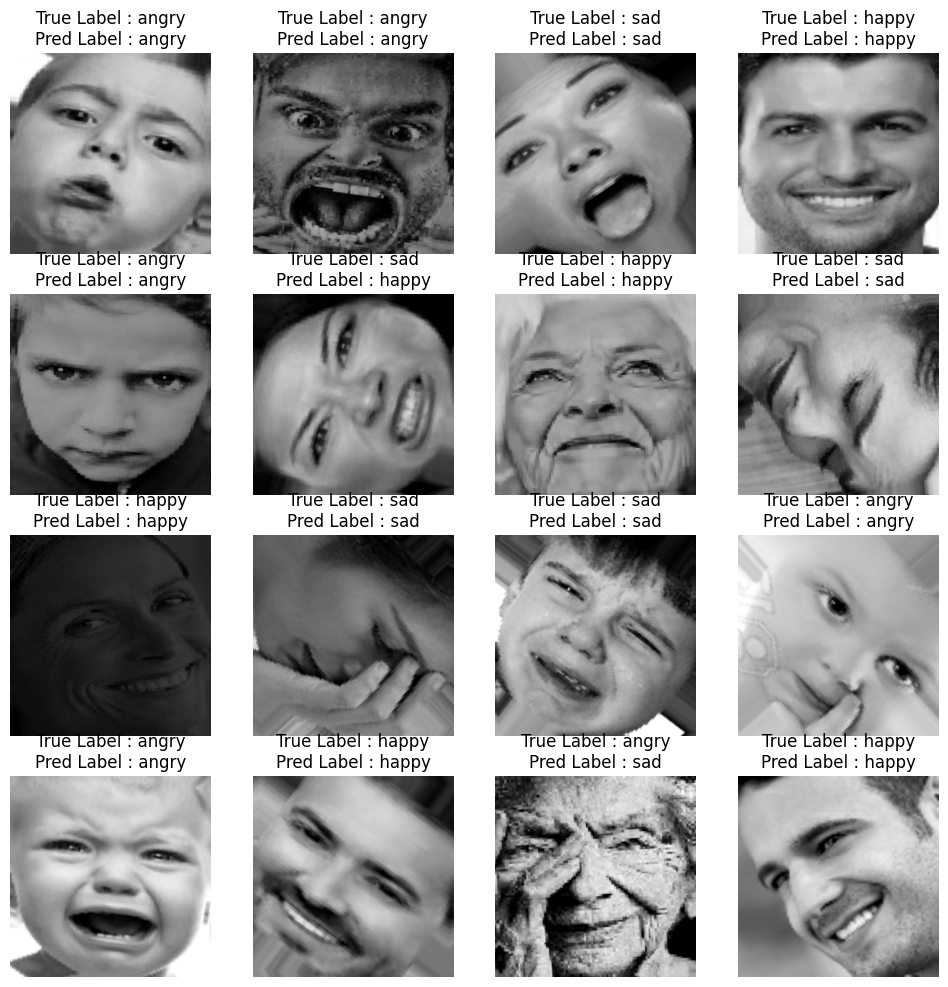

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" "Pred Label : "
              + CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

# Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  predicted.append(resnet_34(im))
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [ ]:
#pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
#lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

In [ ]:
pred = np.argmax(predicted[:-1], axis = -1).flatten()
lab =  np.argmax(labels[:-1], axis = -1).flatten()

[[394  41  80]
 [ 93 805 107]
 [143  67 547]]


Text(0.5, 58.7222222222222, 'Predicted')

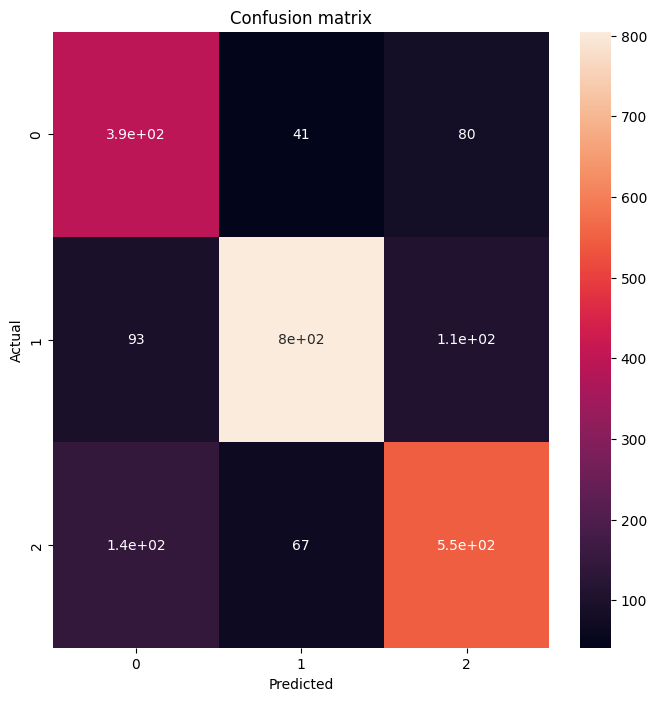

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Load And Save

In [ ]:
lenet_model.save("lenet")

In [ ]:
resnet_34.save("resnet")

In [ ]:
pretrained_model.save("EfficientNet")

In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_HED_colab/

In [ ]:
!cp -r /content/resnet/ /content/drive/MyDrive/Resnet_HED_colab/

In [ ]:
!cp -r /content/EfficientNet/ /content/drive/MyDrive/EfficientNet_HED_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_HED_colab/ /content/lenet/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/dataset/ /content/drive/MyDrive/lenet_HED_colab/

cp: cannot stat '/content/dataset/': No such file or directory


In [ ]:
!cp -r /content/tfrecords/ /content/drive/MyDrive/lenet_HED_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_HED_colab/ /content/tfrecords/

In [ ]:
!cp -r /content/best_weights/ /content/drive/MyDrive/Model_best_weights/

In [ ]:
lenet_model = tf.keras.models.load_model("lenet")

# TFR Records

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
val_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS)] )
    #val_recons_dataset = tf.data.TFRecordDataset(
     #filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>